0      2015-01-01
1      2015-01-02
2      2015-01-03
3      2015-01-04
4      2015-01-05
          ...    
3096   2023-06-24
3097   2023-06-25
3098   2023-06-26
3099   2023-06-27
3100   2023-06-28
Name: timestamp, Length: 3101, dtype: datetime64[ns]


Text(0.5, 1.0, 'Price Trend')

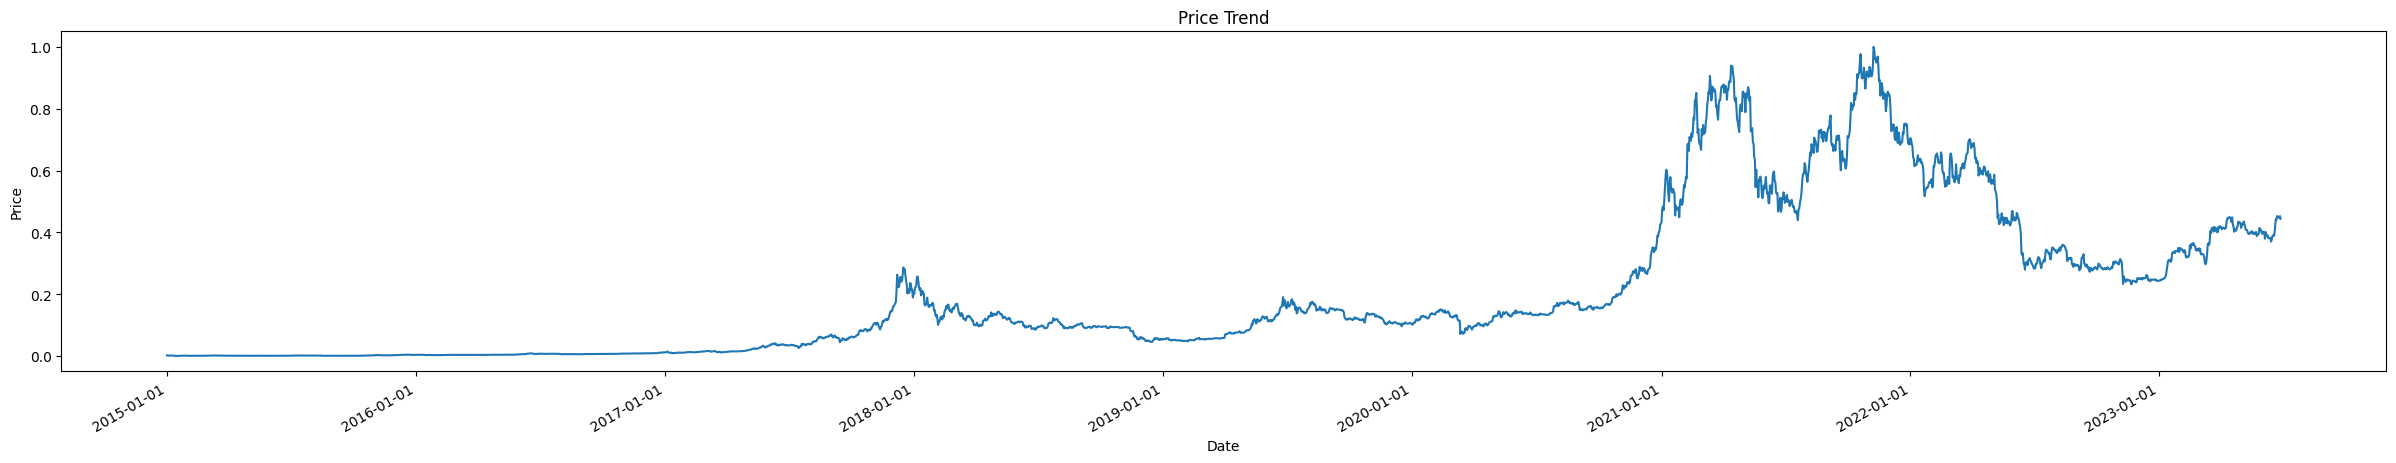

In [209]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
# data_path = 'data/all_filter_update_2500.csv'
df = pd.read_csv('data/BTC-USD.csv')
df['timestamp'] = df['Date']
df['value'] = df['Close']

df['timestamp'] = pd.to_datetime(df['timestamp'])

scaler = MinMaxScaler()
df[['value']]= scaler.fit_transform(df[['value']])

# start_date = pd.to_datetime('2020-01-01')
# end_date = pd.to_datetime('2023-05-31')
# df = df[(df['timestamp']>= start_date) & (df['timestamp'] <= end_date)]
df = df.sort_values('timestamp', ascending=True)


# filtered_df = df.loc[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]

# window_size = 7 # 窗口大小
# # sentiment['pos'] = sentiment['pos'].rolling(window_size).mean()

# df['value'] = df['value'].rolling(window_size).mean()
# df.set_index('timestamp', inplace=True)
# df.index = df.index.shift(window_size, freq='D')
# sentiment = df.reset_index()



print(df['timestamp'])
dates = list(df['timestamp'])
prices = list(df['value'])

# prices
# 绘制价格走势图
plt.figure(figsize=(30, 5))
plt.plot(dates, prices)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Trend')

# plt.xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2023-05-31'))


# lag hour测试

In [210]:
import re
from sklearn.preprocessing import MinMaxScaler
import numpy as np
# sentiment = pd.read_csv(data_path,lineterminator='\n')
sentiment = pd.read_csv("data/tweet_2020_01_full_result.csv")

sentiment = sentiment[sentiment['scores'].notnull()]
# filter
print(len(sentiment))
sentiment = sentiment[sentiment['label'] == 1]
print(len(sentiment))

print(len(sentiment))
thr = 100
sentiment = sentiment[(sentiment['user_follower_count'] > thr) | (sentiment['favorite_count'] > thr) | (sentiment['quote_count'] > thr) | (sentiment['reply_count'] > thr) | (sentiment['retweet_count'] > thr)]
print(len(sentiment))


def show_trend(sentiment, start, end, flag, lag):
    sentiment = sentiment[sentiment['created_at'].notna()]
    sentiment['second'] = pd.to_datetime(sentiment['created_at'], format='%a %b %d %H:%M:%S +0000 %Y')

    # 小时平移
    sentiment.set_index('second', inplace=True)
    sentiment.index = sentiment.index.shift(lag, freq='H')
    sentiment = sentiment.reset_index()

    sentiment['day'] = sentiment['second'].dt.year.astype(str) + '-' + sentiment['second'].dt.month.astype(str) + '-' + sentiment['second'].dt.day.astype(str)
    sentiment['date'] = pd.to_datetime(sentiment['day'])

    # # 将日期列设置为索引
    # sentiment.set_index('date', inplace=True)
    # sentiment['hour']
    sentiment['scores']  = sentiment['scores'].astype('str')
    sentiment['pos'] = sentiment['scores'].str.split('\n').map(lambda row: float(row[0][4:]))
    sentiment['neg'] = sentiment['scores'].str.split('\n').map(lambda row: float(row[1][4:]))
    sentiment['neu'] = sentiment['scores'].str.split('\n').map(lambda row: float(row[2][4:]))

    # sentiment['pos'] = sentiment['pos'] + sentiment['pos'] * sentiment['user_follower_count'] + sentiment['pos'] * sentiment['favorite_count']
    # sentiment['neg'] = sentiment['neg'] + sentiment['neg'] * sentiment['user_follower_count'] + sentiment['neg'] * sentiment['favorite_count']
    # sentiment['neu'] = sentiment['neu'] + sentiment['neu'] * sentiment['user_follower_count'] + sentiment['neu'] * sentiment['favorite_count']

    sentiment = sentiment.groupby(sentiment['date'])[['pos','neg','neu']].mean().reset_index()
    sentiment['metrics'] = sentiment['pos'] - sentiment['neg']
    print(sentiment.columns)
    

    # 归一化
    scaler = MinMaxScaler()
    sentiment[['metrics']]= scaler.fit_transform(sentiment[['metrics']])

    # 滑动窗口平滑
    window_size = 1 # 窗口大小
    sentiment['metrics'] = sentiment['metrics'].rolling(window_size).mean()

    sentiment['metrics_return'] = sentiment['metrics'].pct_change()
    df['value_return'] = df['value'].pct_change()


    # 绘制价格走势图
    # trend = sentiment['metrics_return'].tolist()
    # sen_dates = sentiment['date'].tolist()
    # dates = list(df['timestamp'])
    # prices = list(df['value_return'])
    # print(len(trend),len(sen_dates))
    # print(len(prices))
    # if flag == 1:
    #     plt.figure(figsize=(60, 20))
    # plt.plot(dates, prices,label='Price_return')

    # plt.plot(sen_dates, trend,label='Sentiment_return')

    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # plt.gcf().autofmt_xdate()
    # plt.xlabel('Date')
    # plt.ylabel('trend')
    # plt.title(start+'~'+end)
    # plt.ylim(-0.2,0.2)
    # plt.xlim(pd.Timestamp(start), pd.Timestamp(end))
    # plt.legend()
    # plt.show()

    # 计算相关系数
    sentiment = sentiment[sentiment['metrics_return'].notnull()]
    join = pd.merge(sentiment,df,left_on='date',right_on='timestamp')
    join = join[(join['date']>= pd.Timestamp(start)) & (join['date'] <= pd.Timestamp(end))]
    # print(join)
    
    t1 = join['metrics_return'].to_list()
    t2 = join['value_return'].to_list()
    good = 0
    for i in range(len(t1)):
        if t1[i] * t2[i] > 0:
            good = good + 1
    # print(good/len(t1))
    date = join['date'].to_list()
    corr = np.corrcoef(t1, t2)[0, 1]
    # print(len(date))
    
    return good/len(t1), corr
acc_list = []
corr_list = []
for lag in range(-24,25):
    acc, corr = show_trend(sentiment.copy(),'2020-01-01', '2020-01-31', 0, lag)
    acc_list.append(acc)
    corr_list.append(corr)
    print(lag ,"皮尔森相关系数为:", corr, "准确率为:",acc)

193515
193515
193515
170214
Index(['date', 'pos', 'neg', 'neu', 'metrics'], dtype='object')
-24 皮尔森相关系数为: -0.20190058840846595 准确率为: 0.43333333333333335
Index(['date', 'pos', 'neg', 'neu', 'metrics'], dtype='object')
-23 皮尔森相关系数为: -0.1970838880127367 准确率为: 0.41935483870967744
Index(['date', 'pos', 'neg', 'neu', 'metrics'], dtype='object')
-22 皮尔森相关系数为: -0.14263587664750887 准确率为: 0.41935483870967744
Index(['date', 'pos', 'neg', 'neu', 'metrics'], dtype='object')
-21 皮尔森相关系数为: -0.14635969480299726 准确率为: 0.3870967741935484
Index(['date', 'pos', 'neg', 'neu', 'metrics'], dtype='object')
-20 皮尔森相关系数为: -0.09209843253298527 准确率为: 0.3548387096774194
Index(['date', 'pos', 'neg', 'neu', 'metrics'], dtype='object')
-19 皮尔森相关系数为: -0.06999987826301271 准确率为: 0.3225806451612903
Index(['date', 'pos', 'neg', 'neu', 'metrics'], dtype='object')
-18 皮尔森相关系数为: 0.027995450604827506 准确率为: 0.41935483870967744
Index(['date', 'pos', 'neg', 'neu', 'metrics'], dtype='object')
-17 皮尔森相关系数为: 0.11460856294104856 准确率

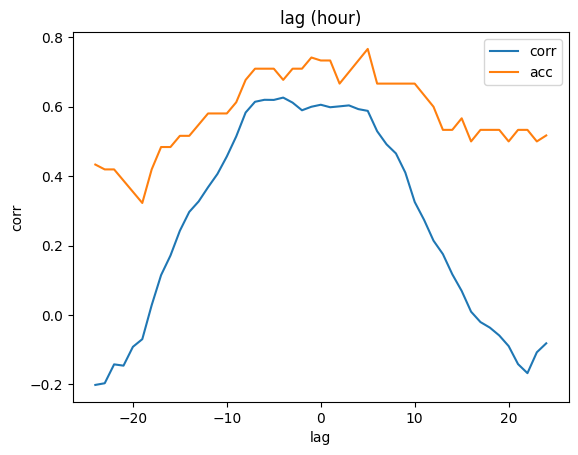

In [211]:
# for i in range(-24,25):
#     print(i, acc_list[i+24], corr_list[i+24])
# 绘制价格走势图
plt.plot(range(-24,25), corr_list,label='corr')
plt.plot(range(-24,25), acc_list,label='acc')

# Add annotations for each point
# for lag, corr, acc in zip(range(-24,25), corr_list, acc_list):
#     if corr > 0.6:
#         plt.text(lag, corr, f'({lag}, {corr:.2f})', ha='center', va='bottom')
#         plt.text(lag, acc, f'({lag}, {acc:.2f})', ha='center', va='top')

plt.xlabel('lag')
plt.ylabel('corr')
plt.title('lag (hour)')
plt.legend()
plt.show()